# Import Libraries

In [ ]:
!pip install pmdarima > /dev/null 2>&1 # Suppress output message

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.linear_model import SGDClassifier
from scipy.stats import pearsonr

# Initial Setting

In [ ]:
ticker = "PPH"

start_date = "2013-05-09"
end_date = "2024-11-22"

df_pph = yf.download(ticker, start=start_date, end=end_date)

df_pph.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PPH,PPH,PPH,PPH,PPH,PPH
Date,,,,,,
2013-05-09,36.945049,45.910000,46.110001,45.709999,45.910000,65000
2013-05-10,37.347412,46.410000,46.419998,46.040001,46.040001,29500
2013-05-13,37.524452,46.630001,46.630001,46.150002,46.299999,24400
2013-05-14,37.830257,47.009998,47.040001,46.630001,46.689999,30000
2013-05-15,38.128002,47.380001,47.650002,47.000000,47.000000,53100


# IQVIA Benchmark

In [ ]:
ticker = "IQV"


df_iqv = yf.download(ticker, start=start_date, end=end_date)



[*********************100%***********************]  1 of 1 completed


# ARIMA model
1. We first use the whole data to determine (p,d,q)
2. Set Up Rolling Window Framework
3. Use that model to slide and train, record the MAPE along

##### Set up the whole data for initial training

In [ ]:
pph_whole = df_pph['Close']
iqv_whole = df_iqv['Close']


In [ ]:
model = auto_arima(
    pph_whole,
    #exogenous=iqv_train,
    seasonal = False,
    stepwise = True,
    trace = True
)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5826.418, Time=4.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5824.887, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5826.171, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5826.220, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5824.287, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5826.998, Time=1.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.092 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# model_1 = ARIMA(pph_whole, order=(0, 1, 0))  # Set your (p, d, q) parameters
# model_1 = model_1.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# forecast = model_1.forecast(steps=1)
# forecast[0]

Set up the rolling window framework



In [ ]:
# Step 1: Initial setting
train_size = int(len(pph_whole) * 0.7)  # 70% for training
test_size = len(pph_whole) - train_size  # Remaining 30% for testing
rolling_window_size = train_size  # Keep the rolling window size fixed


# Do split
train_data = pph_whole[:train_size]
test_data = pph_whole[train_size:]

# CONVERT pd to NumPy for CLEAR FORMAT
# Now they are single dimension data set
train_data = train_data.to_numpy().ravel()
test_data = test_data.to_numpy().ravel()




# Step 2: Rolling window predictions
rolling_predictions = []  # List to store predictions
true_values = []  # List to store true values for evaluation

# This the initial rolling_train
rolling_train = train_data.copy()


Slide the window and test

In [ ]:
i = 0


p,d,q = 0,1,0
for test_point in test_data:
    # Step 3: Fit the ARIMA model on the rolling training window
    model = ARIMA(rolling_train, order=(p, d, q))
    model_fit = model.fit()

    # Step 4: Forecast the next point (1-step ahead prediction)
    forecast = model_fit.forecast(steps=1) # It is still np array
    forecast = forecast[0] # It is now single value

    rolling_predictions.append(forecast)  # Save prediction
    true_values.append(test_point)  # Save actual value

    # Step 5: Update the rolling training window
    # 1. Remove the oldest point 2. Add the current test point
    rolling_train = np.append(rolling_train[1:], test_point)

    i +=1
    print(str(i) + "points are tested.") if i % 100 == 0 else None


print("Testing finished")

100points are tested.
200points are tested.
300points are tested.
400points are tested.
500points are tested.
600points are tested.
700points are tested.
800points are tested.
Testing finished


# Model evaluation

Real value and prediction

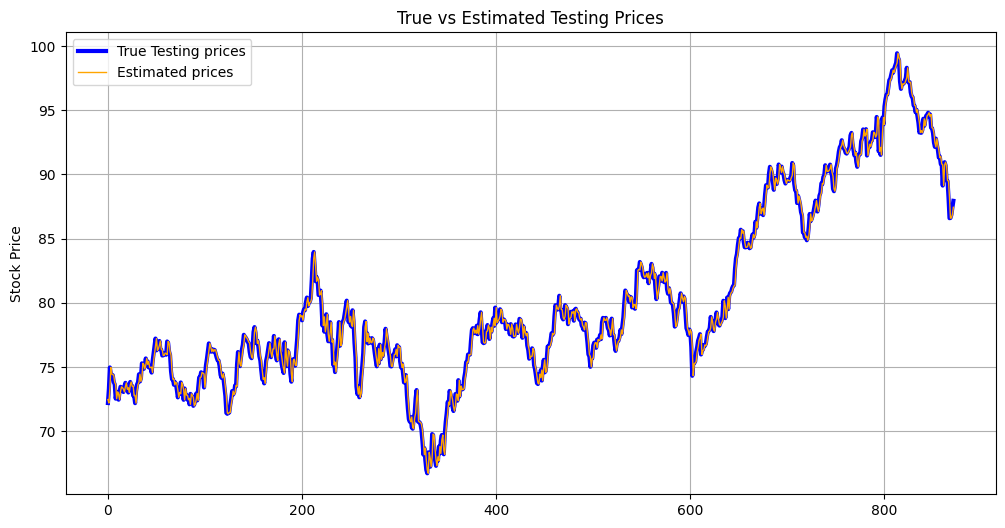

In [ ]:
# Plot the true testing data and estimated data
plt.figure(figsize=(12, 6))
plt.plot(true_values, label="True Testing prices", linestyle='-', linewidth=3, color='blue')
plt.plot(rolling_predictions, label="Estimated prices", linestyle='-', linewidth=1, color='orange')

# Add labels, legend, and grid
plt.xlabel("")
plt.ylabel("Stock Price")
plt.title("True vs Estimated Testing Prices")
plt.legend()
plt.grid()
plt.show()

Residual analysis 1: residual plot

Mean Absolute Error (MAE): 0.52


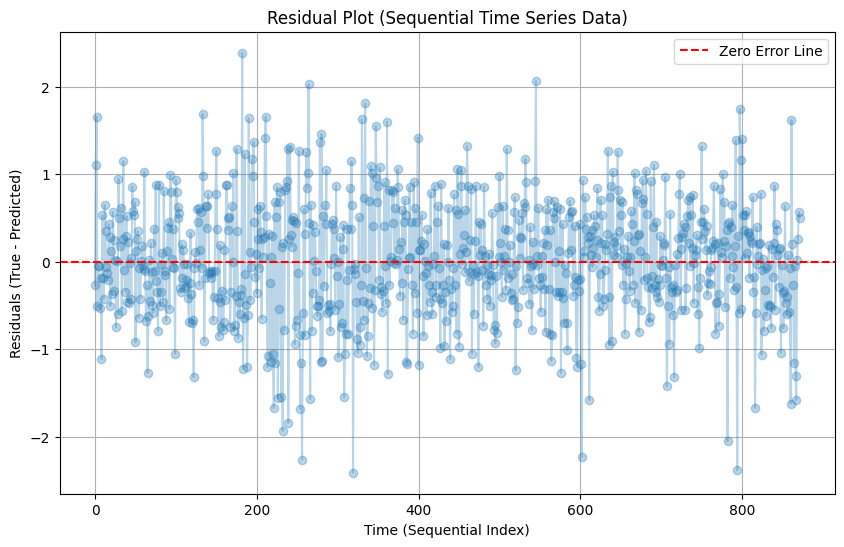

In [ ]:
 # Step 6: Evaluate the model
mae = mean_absolute_error(true_values, rolling_predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate residuals
residuals = np.array(true_values) - np.array(rolling_predictions)

# Plot the residuals

# Residual plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(residuals)), residuals, marker='o', linestyle='-', alpha=0.3)
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel("Time (Sequential Index)")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residual Plot (Sequential Time Series Data)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test); print("\n")
print("We fail to reject Null and conclude that the residuals are independent.")

     lb_stat  lb_pvalue
10  9.905473   0.448825


We fail to reject Null and conclude that the residuals are independent.


Residual analysis 2: box plot

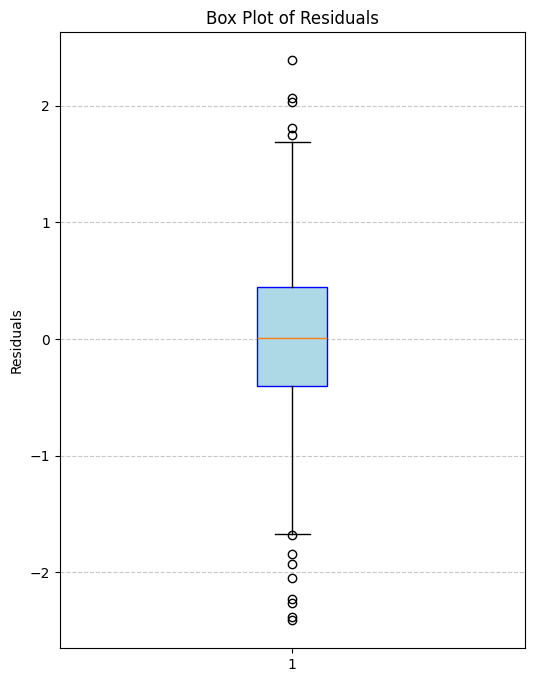

In [ ]:
# Create a box plot
plt.figure(figsize=(6, 8))
plt.boxplot(residuals, vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue", color="blue"))
plt.title("Box Plot of Residuals")
plt.ylabel("Residuals")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## ARIMAX with IQV

In [ ]:
exog_model = auto_arima(
    pph_whole,
    X = iqv_whole,
    seasonal=False, # Set to True and specify seasonal period if necessary
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4937.009, Time=7.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4940.507, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4941.659, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4941.666, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4939.088, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4939.861, Time=4.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4945.602, Time=1.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4945.069, Time=13.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4943.829, Time=4.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4943.555, Time=5.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4940.549, Time=4.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4946.801, Time=2.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=12.49 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4935.622, Time=5.78 sec
 ARIMA(1,1,2)(0,0,0)[0]             

We can see that the extraneuous information does not add to our model, which means we can just use the stock price per se. Given parameter parsimony, we can still use (p,d,q) = (0,1,0)

# Take profit & Stop loss

In [ ]:
# Compute daily take profit and stop loss percentages
df_pph['TakeProfitPct'] = (df_pph['High'] - df_pph['Open']) / df_pph['Open']  # High relative to Open
df_pph['StopLossPct'] = (df_pph['Low'] - df_pph['Open']) / df_pph['Open']    # Low relative to Open

# Calculate mean thresholds
take_profit_mean = df_pph['TakeProfitPct'].mean()
stop_loss_mean = df_pph['StopLossPct'].mean()

# Print results
print(f"Take Profit (Mean %): {take_profit_mean * 100:.2f}%")
print(f"Stop Loss (Mean %): {stop_loss_mean * 100:.2f}%")

Take Profit (Mean %): 0.52%
Stop Loss (Mean %): -0.58%


In [ ]:
df_pph['TR'] = df_pph[['High', 'Low', 'Open']].apply(lambda x: max(x[0] - x[1], abs(x[0] - x[2]), abs(x[1] - x[2])), axis=1)
atr = df_pph['TR'].mean()
take_profit_atr = atr * 2  # Take profit at 2x ATR
stop_loss_atr = atr * 1.5  # Stop loss at 1.5x ATR
print(f"ATR Take Profit: {take_profit_atr:.2f}")
print(f"ATR Stop Loss: {stop_loss_atr:.2f}")


<ipython-input-28-6f7a363d730a>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pph['TR'] = df_pph[['High', 'Low', 'Open']].apply(lambda x: max(x[0] - x[1], abs(x[0] - x[2]), abs(x[1] - x[2])), axis=1)


ATR Take Profit: 1.44
ATR Stop Loss: 1.08


# Win & lose ratio

In [ ]:
initial_prev = train_data[-1]

testing_length = len(test_data)


# true_values, rolling_predictions

prediction_direction_accuracy = []

curr_prev = initial_prev
for i in range(testing_length):
    if rolling_predictions[i] >= curr_prev:
        pred_direction = 1
    elif rolling_predictions[i] < curr_prev:
        pred_direction = 0

    if true_values[i] >= curr_prev:
        true_direction = 1
    elif true_values[i] < curr_prev:
        true_direction = 0

    if pred_direction == true_direction:
        prediction_direction_accuracy.append(1)
    else:
        prediction_direction_accuracy.append(0)

    curr_prev = true_values[i]

accuracy = sum(prediction_direction_accuracy) / len(prediction_direction_accuracy)
print(f"Prediction Direction Accuracy: {accuracy * 100:.2f}%")

Prediction Direction Accuracy: 50.80%
